# Sentinel Hub FIS services

First we need to import some things. 

In [1]:
import urllib.request
import json 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#constants
plt.rcParams['figure.figsize'] = [10, 5]
INSTANCE_ID = 'ce55231e-6f5c-4910-84a4-2768a2c585f1'

## FIS URL

### Example 1: URL

In [4]:
url_1 = "http://services.sentinel-hub.com/ogc/fis/" + INSTANCE_ID + \
        "?LAYER=NDVI&STYLE=INDEX&CRS=EPSG%3A3857&TIME=2015-01-01%2F2015-10-01" + \
        "&BBOX=1550369.86,5586056.25,1547498.69,5584861.92" + \
        "&RESOLUTION=10&MAXCC=5&BINS=100"
print(url_1)

http://services.sentinel-hub.com/ogc/fis/ce55231e-6f5c-4910-84a4-2768a2c585f1?LAYER=NDVI&STYLE=INDEX&CRS=EPSG%3A3857&TIME=2015-01-01%2F2015-10-01&BBOX=1550369.86,5586056.25,1547498.69,5584861.92&RESOLUTION=10&MAXCC=5&BINS=100


You can click on the obove link and see the result in new tab. Or you can show the result in Notebook (next example). 

### Example 2: URL

In [5]:
url_2 = "http://services.sentinel-hub.com/ogc/fis/" + INSTANCE_ID + \
        "?LAYER=NDVI&STYLE=INDEX&CRS=EPSG%3A3857&TIME=2015-01-01%2F2015-10-01" + \
        "&BBOX=1550369.86,5586056.25,1547498.69,5584861.92&RESOLUTION=10" + \
        "&MAXCC=5&service=FIS"
print(url_2)
with urllib.request.urlopen(url_2) as url:
    data = json.loads(url.read().decode())
    print(data)

http://services.sentinel-hub.com/ogc/fis/ce55231e-6f5c-4910-84a4-2768a2c585f1?LAYER=NDVI&STYLE=INDEX&CRS=EPSG%3A3857&TIME=2015-01-01%2F2015-10-01&BBOX=1550369.86,5586056.25,1547498.69,5584861.92&RESOLUTION=10&MAXCC=5&service=FIS
{'C0': [{'date': '2015-08-30', 'basicStats': {'min': -0.4982817769050598, 'max': 0.7768157720565796, 'mean': 0.14745325461520012, 'stDev': 0.3547476774468206}}, {'date': '2015-07-11', 'basicStats': {'min': -0.45623835921287537, 'max': 0.8112759590148926, 'mean': 0.201793853400787, 'stDev': 0.31485074950304787}}]}


The display could be more readable, similar to display in new tab.

In [6]:
print(json.dumps(data, indent=4, sort_keys=True))

{
    "C0": [
        {
            "basicStats": {
                "max": 0.7768157720565796,
                "mean": 0.14745325461520012,
                "min": -0.4982817769050598,
                "stDev": 0.3547476774468206
            },
            "date": "2015-08-30"
        },
        {
            "basicStats": {
                "max": 0.8112759590148926,
                "mean": 0.201793853400787,
                "min": -0.45623835921287537,
                "stDev": 0.31485074950304787
            },
            "date": "2015-07-11"
        }
    ]
}


## Sentinel Hub FIS web services from within Python

In [40]:
from sentinelhub import FisRequest, WmsRequest
from sentinelhub import CRS
from sentinelhub import BBox
from sentinelhub import Geometry
from sentinelhub import DataSource

from shapely.geometry import Polygon
from sentinelhub import CustomUrlParam

### Example 3: FIS request

First, we will create an example same as url_2 (see Example 2: URL). First we define the geometry.

In [8]:
bbox = BBox(bbox=(1550369.86,5586056.25,1547498.69,5584861.92), crs=CRS.POP_WEB)

Than we creat FisRequest. In this example with parameters:

* layer: name of the layer (from Sentinel Hub Configuration Utility https://apps.sentinel-hub.com/configurator)
* geometry_list: list of geometry objects (even if there is one object, it must be in a list)
* time: Time range from which to retrieve the images. The service computes statistics for each image from the time range that fits the prescribed criteria.
* style: Specified style (overrides the one specified in the layer configuration).
* resolution: Specifies the spatial resolution, in meters per pixel, of the image from which the statistics are to be estimated.
* maxcc: The maximum allowable cloud coverage in percent (from 0 to 1).
* instance_id: id of the sentinelhub service

In [41]:
fis_request_3 = FisRequest(layer='NDVI',
                 geometry_list=[bbox],
                 time=("2015-01-01", "2015-10-01"),
                 style="INDEX",
                 resolution="10m",
                 maxcc=0.05,
                 instance_id=INSTANCE_ID)

To get data, we have to cal request_dat() function. We see that the values are the same as in the example 2. 

In [10]:
fis_data_3 = fis_request_3.get_data()
fis_data_3

[{'C0': [{'date': '2015-08-30',
    'basicStats': {'min': -0.4982817769050598,
     'max': 0.7768157720565796,
     'mean': 0.147061206349152,
     'stDev': 0.3545088463438654}},
   {'date': '2015-07-11',
    'basicStats': {'min': -0.45623835921287537,
     'max': 0.8112759590148926,
     'mean': 0.20150179267134388,
     'stDev': 0.3146108980399613}}]}]

This is the statistics of two image. We can see them with WmsRequest.

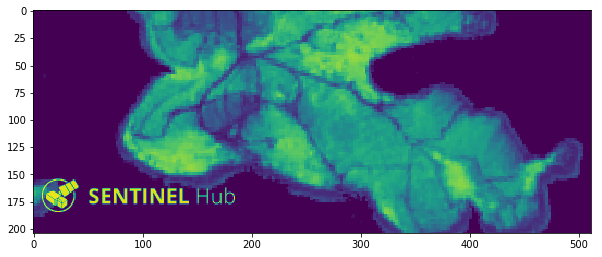

In [45]:
wms_ndvi_request = WmsRequest(layer='NDVI',
                 bbox= bbox,
                 time=("2015-01-01", "2015-10-01"),
                 width=512,
                 maxcc=0.05,
                 instance_id=INSTANCE_ID)
wms_ndvi_img = wms_ndvi_request.get_data()
plt.imshow(wms_ndvi_img[0])

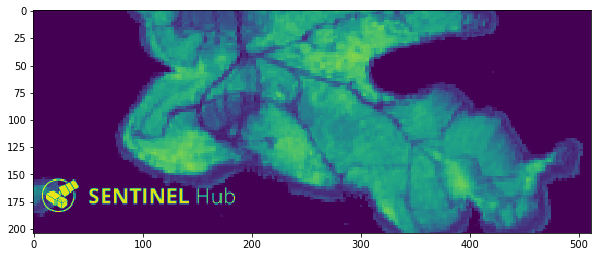

In [46]:
plt.imshow(wms_ndvi_img[1])

### Example 4: FIS request

First we neeed to define geometry. This is the list of objects, either BBox or Geometry. Since in geometry_list there culd be multiple object, we will define a few. 

In [11]:
wgs84_bbox = BBox(bbox=[46.16, -16.15, 46.51, -15.58], crs=CRS.WGS84)
pop_web_bbox = BBox(bbox=(1292344.0, 5195920.0, 1310615.0, 5214191.0),
                    crs=CRS.POP_WEB)
wgs84_geometry = Geometry(polygon=Polygon([(-5.13, 48),
                                           (-5.23, 48.09),
                                           (-5.13, 48.17),
                                           (-5.03, 48.08),
                                           (-5.13, 48)]),
                          crs=CRS.WGS84)

pop_web_geometry = Geometry(polygon=Polygon([(1292344.0, 5205055.5),
                                             (1301479.5, 5195920.0),
                                             (1310615.0, 5205055.5),
                                             (1301479.5, 5214191.0),
                                             (1292344.0, 5205055.5)]),
                            crs=CRS.POP_WEB)

In [12]:
fis_request_4 = FisRequest(layer='TRUE-COLOR-S2-L1C',
                 geometry_list=[wgs84_bbox],
                 time=('2017-1-1', '2017-2-1'),
                 resolution="100m",
                 bins= 5,
                 instance_id=INSTANCE_ID)
fis_data_4 = fis_request_4.get_data()

In [13]:
fis_data_4

[{'C0': [{'date': '2017-01-24',
    'basicStats': {'min': 0.0,
     'max': 0.9629629850387573,
     'mean': 0.2407736771392483,
     'stDev': 0.11643368886648504},
    'histogram': {'bins': [{'value': 0.21475063181079024, 'count': 213270.0},
      {'value': 0.33711445726544026, 'count': 83.0},
      {'value': 0.4557369609034554, 'count': 21819.0},
      {'value': 0.6714087652611582, 'count': 1869.0},
      {'value': 0.8647433344523109, 'count': 75.0}]}},
   {'date': '2017-01-14',
    'basicStats': {'min': 0.0,
     'max': 1.0,
     'mean': 0.40865061926562807,
     'stDev': 0.20581413586775082},
    'histogram': {'bins': [{'value': 0.11958333353201549, 'count': 3.0},
      {'value': 0.25558441494927386, 'count': 116801.0},
      {'value': 0.4681561940896856, 'count': 92281.0},
      {'value': 0.7144405389455128, 'count': 11251.0},
      {'value': 0.9418733007646433, 'count': 16780.0}]}},
   {'date': '2017-01-04',
    'basicStats': {'min': 0.0,
     'max': 1.0,
     'mean': 0.4188135077

Lets take a look at the returned data. It is a list with one object in it, because the geometry is a list with one object. 
There are 3 chanells (C0, C1, C2), becuse we have chosen layer TRUE-COLOR-S2-L1C, which has three chanells (B04,B03,B02). 
For every chanell we have 3 dates (2017-01-04, 2017-01-14, 2017-01-24). This are the dates betwen start and end date (2017-1-1, 2017-2-1) with data. 
For every geometry/chanell/date combination there are 2 things:

* basic statistics: min, max, mean, standard deviation,
* histogram (bins) with values and counts (if there is parameter bins present).  

#### Plot the data

We want to visualise/plot the data. For that we create a function to convert JSON data to two pandas dataframes: one for statistics and one for histograms. 

In [14]:
import pandas as pd

def fis_request_data_to_dataframe(fis_request_data):
    """ Creates one or two dataframes from fis request data 
    
    """
    df_stat = pd.DataFrame(columns=['geometry','chanell','date',
                                    'min','max','mean','stdev'])
    df_histogram = pd.DataFrame(columns=['geometry','chanell',
                                         'date','value','counts'])

    for geometry_index, data in enumerate(fis_request_data):
        for chanell in data:
            for element in data[chanell]:
                stat = {"geometry": geometry_index, 
                        "chanell": chanell, 
                        "date": element["date"], 
                        "min": element["basicStats"]["min"],
                        "max": element["basicStats"]["max"],
                        "mean": element["basicStats"]["mean"],
                        "stdev": element["basicStats"]["stDev"]}
                df_stat = df_stat.append(stat, ignore_index=True)

                if "histogram" in element: 
                    for bin_ in element["histogram"]["bins"]:
                        histogram = {"geometry": geometry_index, 
                                     "chanell": chanell, 
                                     "date": element["date"],
                                     "value": bin_["value"],
                                     "counts": bin_["count"]}
                        df_histogram = df_histogram.append(histogram, 
                                                           ignore_index=True)
    df_stat['date'] = pd.to_datetime(df_stat['date'])
    df_histogram['date'] = pd.to_datetime(df_histogram['date'])
    
    return (df_stat, df_histogram)

In [15]:
df_stat_4, df_histogram_4 = fis_request_data_to_dataframe(fis_data_4)

In [16]:
df_stat_4

,geometry,chanell,date,min,max,mean,stdev
0,0,C0,2017-01-24,0.00000,0.962963,0.240774,0.116434
1,0,C0,2017-01-14,0.00000,1.000000,0.408651,0.205814
2,0,C0,2017-01-04,0.00000,1.000000,0.418814,0.257917
3,0,C1,2017-01-24,0.07850,0.964704,0.265425,0.064523
4,0,C1,2017-01-14,0.00625,1.000000,0.393058,0.187417
5,0,C1,2017-01-04,0.00000,1.000000,0.436817,0.233376
6,0,C2,2017-01-24,0.09275,0.951130,0.264794,0.046808
7,0,C2,2017-01-14,0.12300,1.000000,0.390798,0.190190
8,0,C2,2017-01-04,0.03000,1.000000,0.451518,0.233201


In [17]:
df_histogram_4

,geometry,chanell,date,value,counts
0,0,C0,2017-01-24,0.214751,213270.0
1,0,C0,2017-01-24,0.337114,83.0
2,0,C0,2017-01-24,0.455737,21819.0
3,0,C0,2017-01-24,0.671409,1869.0
4,0,C0,2017-01-24,0.864743,75.0
5,0,C0,2017-01-14,0.119583,3.0
6,0,C0,2017-01-14,0.255584,116801.0
7,0,C0,2017-01-14,0.468156,92281.0
8,0,C0,2017-01-14,0.714441,11251.0
9,0,C0,2017-01-14,0.941873,16780.0


In [18]:
df_plot_4a = df_stat_4.loc[df_stat_4["chanell"]=="C0"]
df_plot_4a

,geometry,chanell,date,min,max,mean,stdev
0,0,C0,2017-01-24,0.0,0.962963,0.240774,0.116434
1,0,C0,2017-01-14,0.0,1.000000,0.408651,0.205814
2,0,C0,2017-01-04,0.0,1.000000,0.418814,0.257917


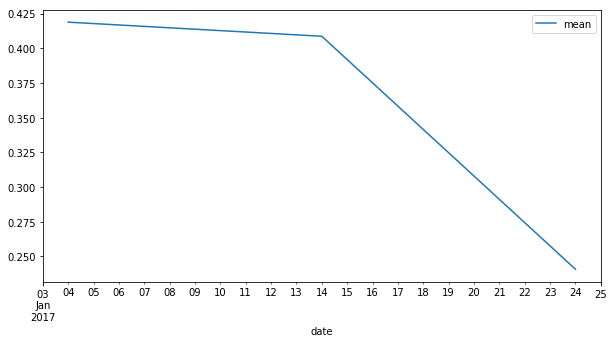

In [19]:
line = df_plot_4a.plot.line(x="date", y="mean")

In [20]:
df_plot_4b = df_histogram_4.loc[df_histogram_4["chanell"] == "C0"]
df_plot_4b = df_plot_4b.loc[df_plot_4b["date"] == "2017-01-24"]
df_plot_4b

,geometry,chanell,date,value,counts
0,0,C0,2017-01-24,0.214751,213270.0
1,0,C0,2017-01-24,0.337114,83.0
2,0,C0,2017-01-24,0.455737,21819.0
3,0,C0,2017-01-24,0.671409,1869.0
4,0,C0,2017-01-24,0.864743,75.0


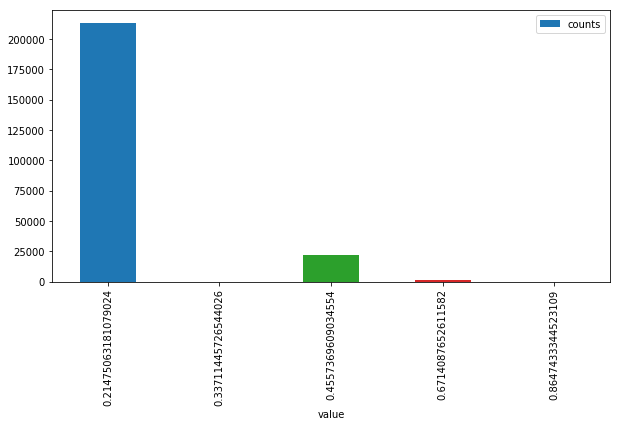

In [21]:
df_plot_4b.plot.bar(x="value", y="counts")

### Example 5: FIS request

This is FIS request for two geometries and longer time frame. 

In [22]:
fis_request_5 = FisRequest(layer='TRUE-COLOR-S2-L1C',
                 geometry_list=[wgs84_bbox, pop_web_bbox],
                 time=('2017-1-1', '2017-10-1'),
                 resolution="100m",
                 style="REFLECTANCE",
                 bins=10,
                 instance_id=INSTANCE_ID)
fis_data_5 = fis_request_5.get_data()
df_stat_5, df_histogram_5 = fis_request_data_to_dataframe(fis_data_5)

We can see the dataframe description or we can try to find unique elements. 

In [24]:
df_stat_5.describe(include="all")

,geometry,chanell,date,min,max,mean,stdev
count,312.0,312,312,312.000000,312.000000,312.000000,312.000000
unique,2.0,3,68,NaN,NaN,NaN,NaN
top,1.0,C0,2017-02-03 00:00:00,NaN,NaN,NaN,NaN
freq,204.0,104,6,NaN,NaN,NaN,NaN
first,NaN,NaN,2017-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,2017-10-01 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.125259,0.892857,0.377950,0.110297
std,NaN,NaN,NaN,0.120241,0.106823,0.184556,0.063148
min,NaN,NaN,NaN,0.000000,0.606750,0.172325,0.026861
25%,NaN,NaN,NaN,0.023187,0.836625,0.275631,0.058885


We have:

* 312 elements in dataframe
* 2 geometris
* 3 chanells
* 68 dates
* first date, last date 

In [25]:
df_stat_5.geometry.unique(), df_stat_5.chanell.unique(), df_stat_5.date.unique()

(array([0, 1], dtype=object),
 array(['C0', 'C1', 'C2'], dtype=object),
 array(['2017-10-01T00:00:00.000000000', '2017-09-26T00:00:00.000000000',
        '2017-09-21T00:00:00.000000000', '2017-09-11T00:00:00.000000000',
        '2017-09-06T00:00:00.000000000', '2017-09-01T00:00:00.000000000',
        '2017-08-27T00:00:00.000000000', '2017-08-22T00:00:00.000000000',
        '2017-08-17T00:00:00.000000000', '2017-08-12T00:00:00.000000000',
        '2017-08-07T00:00:00.000000000', '2017-08-02T00:00:00.000000000',
        '2017-07-28T00:00:00.000000000', '2017-07-23T00:00:00.000000000',
        '2017-07-18T00:00:00.000000000', '2017-07-13T00:00:00.000000000',
        '2017-07-08T00:00:00.000000000', '2017-07-03T00:00:00.000000000',
        '2017-06-23T00:00:00.000000000', '2017-06-13T00:00:00.000000000',
        '2017-06-03T00:00:00.000000000', '2017-05-24T00:00:00.000000000',
        '2017-05-14T00:00:00.000000000', '2017-05-04T00:00:00.000000000',
        '2017-04-24T00:00:00.000000000',

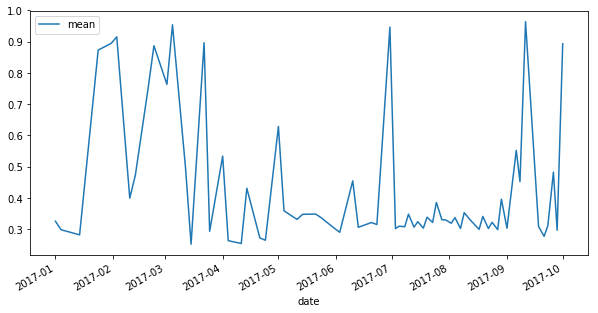

In [26]:
df_plot_5a = df_stat_5.loc[(df_stat_5.chanell=="C2") & (df_stat_5.geometry==1)]
df_plot_5a.plot.line(x="date", y = "mean")

In [35]:
df_plot_5b = df_histogram_5.loc[(df_histogram_5.chanell=="C2") & 
                                (df_histogram_5.geometry==1) &
                               (df_histogram_5.date=="2017-05-04")]
df_plot_5b

,geometry,chanell,date,value,counts
2880,1,C2,2017-05-04,0.073750,1.0
2881,1,C2,2017-05-04,0.167000,2.0
2882,1,C2,2017-05-04,0.234177,8243.0
2883,1,C2,2017-05-04,0.319877,5963.0
2884,1,C2,2017-05-04,0.420738,1115.0
2885,1,C2,2017-05-04,0.526228,576.0
2886,1,C2,2017-05-04,0.635823,555.0
2887,1,C2,2017-05-04,0.749396,321.0
2888,1,C2,2017-05-04,0.841196,310.0
2889,1,C2,2017-05-04,0.936434,1139.0


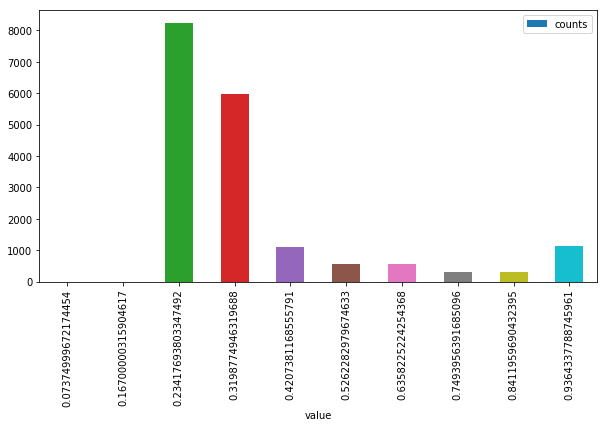

In [37]:
df_plot_5b.plot.bar(x="value", y="counts")

In [31]:
df_plot_5b.describe(include="all")

,geometry,chanell,date,value,counts
count,680.0,680,680,680.000000,680.000000
unique,1.0,1,68,NaN,NaN
top,1.0,C2,2017-05-14 00:00:00,NaN,NaN
freq,680.0,680,10,NaN,NaN
first,NaN,NaN,2017-01-01 00:00:00,NaN,NaN
last,NaN,NaN,2017-10-01 00:00:00,NaN,NaN
mean,NaN,NaN,NaN,0.533667,1822.500000
std,NaN,NaN,NaN,0.211870,3110.449331
min,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,0.366695,12.000000
